In [1]:
from data import datasets
import albumentations as A
from data import custum_collate
import numpy as np
import glob, cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import albumentations.pytorch
import utility
import torch
import torch.distributed as dist
import torch.nn as nn

import torchvision
import os
import random
from yolox.exp import Exp
from yolox.utils import postprocess
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data_utils
import datetime
from shutil import copyfile
import time
import modules.evaluation as evaluate

import torch.nn.functional as F
import scipy

In [2]:
#--------------Base Param------------
w_h = [1280, 480]
BATCH_SIZE = 8
num_workers =1
file_root = '/home/etri/road-dataset/road/ETRI_Dataset_Separate/'
#--------------Base Param------------
#--------------Class Param------------
all_classes =  ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL','VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L','Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
len_class = len(all_classes)
agent_classes =  ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL']
loc_classes =  ['VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L']
action_classes =  ['Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
class_nums = [len(agent_classes), len(loc_classes), len(action_classes)]
#--------------Class Param------------

#--------------Learning Rate Param------------
T_0=20 # Initial Cycle Length
T_mult=2 # Cycle Length multiplier
eta_max=1e-4 # Max LR
T_up=10  # WarmUp Length
gamma=0.5 # LR reducer

start_epoch =0
num_epochs = 120
best_acc = -1

#--------------Learning Rate Param------------

In [3]:

def postprocess(prediction, num_classes, conf_thre=0.1, nms_thre=0.85):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(
            image_pred[:, 5 : 5 + 7], 1, keepdim=True
        )
        loc_conf, loc_pred = torch.max(
            image_pred[:, 5+7 : 5 + 7+9], 1, keepdim=True
        )
        action_conf, action_pred = torch.max(
            image_pred[:, 5+7+9 : 5 + 7 + 9+19], 1, keepdim=True
        )
        reid_feat  = image_pred[:,-256 : ]
        
        action_idx = (image_pred[:, 5+7+9 : 5 + 7 + 9+19]+0.6)//1
        loc_idx = F.one_hot(loc_pred,9).squeeze().float()
        agent_idx = F.one_hot(class_pred,7).squeeze().float()
        
        conf_mask = (image_pred[:, 4] * class_conf.squeeze()>= conf_thre).squeeze()
        # _, conf_mask = torch.topk((image_pred[:, 4] * class_conf.squeeze()), 1000)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float(), agent_idx,loc_idx,action_idx,reid_feat), 1)
        detections = detections[conf_mask]
        if not detections.size(0):
            continue

        nms_out_index = torchvision.ops.batched_nms(
            detections[:, :4],
            detections[:, 4] * detections[:, 5],
            torch.zeros(detections.shape[0]),
            nms_thre,
        )
        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or 2  # line thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=1)

COLORS =[
        [255, 0, 0],     # Red
        [0, 255, 0],     # Green
        [0, 0, 255],     # Blue
        [255, 255, 0],   # Yellow
        [255, 0, 255],   # Magenta
        [0, 255, 255],   # Cyan
        [128, 0, 0],     # Maroon
        [0, 128, 0],     # Green (dark)
        [0, 0, 128],     # Navy
        [128, 128, 0],   # Olive
        [128, 0, 128],   # Purple
        [0, 128, 128],   # Teal
        [255, 165, 0],   # Orange
        [210, 180, 140], # Tan
        [255, 192, 203], # Pink
        [0, 128, 128],   # Teal
        [255, 99, 71],   # Tomato
        [139, 69, 19],   # Saddle Brown
        [0, 128, 0],     # Green (dark)
        [255, 20, 147]   # Deep Pink
    ]
#for _ in range(len(agent_list)):
#    COLORS.append([np.random.randint(0, 255) for _ in range(3)])

In [4]:

def seg_plot_one_box(x,idx, img, mask, color=None, label=None,track_id=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or 2  # line thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    
    c1, c2 = (np.clip(int(x[0]),0,mask.shape[1]), np.clip(int(x[1]),0,mask.shape[0])), (np.clip(int(x[2]),0,mask.shape[1]), np.clip(int(x[3]),0,mask.shape[0]))
    cv2.rectangle(img, c1, c2, color, thickness=1)
    copy_mask = mask[c1[1]:c2[1],c1[0]:c2[0]]==idx
    
    mask_img = np.expand_dims(copy_mask, axis=2)
    mask_img = np.repeat(mask_img, 3, axis=2)
    #print(copy_mask.shape, COLORS[idx%])
    if track_id==None:
        img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]= img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]*0.6 + np.array(COLORS[idx%20])*0.4
    else:
        img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]= img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]*0.6 + np.array(COLORS[track_id%20])*0.4
        

In [5]:
#Train transfrom + Augmentations

train_transform =  A.Compose(
    [
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    #A.Normalize(),
    A.pytorch.transforms.ToTensorV2()],
    bbox_params=A.BboxParams(format='albumentations', label_fields=['category_ids']),
)

transform = A.Compose(
    [
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    A.pytorch.transforms.ToTensorV2()]
)
train_dataset = datasets.Infra_dataset(train=False,class_nums = class_nums,transform=train_transform,file_root = file_root)
train_data_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers,collate_fn=custum_collate, pin_memory=True, drop_last=True)

dataset length :  1365 1365


In [6]:
#Model Create

exp = Exp(class_nums = class_nums)
model = exp.get_model()
#model = load_my_state_dict(model,ckpt["model"])
#ckpt = torch.load('/home/etri/road-dataset/Track_YOLOX/last.ckpt')
#model = utility.load_my_state_dict(model,ckpt["state_dict"])

ckpt = torch.load('./output/2023-07-05-17-07-38/checkpoints/last.pth.tar', map_location='cpu')
model = utility.load_my_state_dict(model,ckpt['state_dict'])

Imcompatible:  backbone.lateral_conv0.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.conv2.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.conv3.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.m.0.conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.m.0.conv2.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.m.1.conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.m.1.conv2.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.m.2.conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p4.m.2.conv2.bn.num_batches_tracked
Imcompatible:  backbone.reduce_conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p3.conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p3.conv2.bn.num_batches_tracked
Imcompatible:  backbone.C3_p3.conv3.bn.num_batches_tracked
Imcompatible:  backbone.C3_p3.m.0.conv1.bn.num_batches_tracked
Imcompatible:  backbone.C3_p3.m.0.conv2.bn.num_batches_tracked
Imcompatible:  backbo

In [7]:
tl = iter(train_data_loader)
exp = Exp()
model.cuda()
model.eval()

/home/etri/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(128, 64, kernel

In [8]:

def get_individual_labels(gt_boxes, tgt_labels):
    # print(gt_boxes.shape, tgt_labels.shape)
    new_gts = np.zeros((gt_boxes.shape[0]*30, 6))
    ccc = 0
    for n in range(tgt_labels.shape[0]):
        for t in range(tgt_labels.shape[1]):
            if tgt_labels[n,t]>0:
                new_gts[ccc, :4] = gt_boxes[n,:]
                new_gts[ccc, 4] = t
                new_gts[ccc, 5] = ccc
                ccc += 1
    return new_gts[:ccc,:]

def pair_boxes(gt_boxes, det_boxes, iou_thresh=0.5):
    #print("GT :",gt_boxes[0].astype('int'))
    #print("DB3:",det_boxes[0][0].astype('int'))
    pairs = []

    frame_det_boxes = np.copy(det_boxes)

    # check if there are dection for class cls in nf frame
    if frame_det_boxes.shape[0] > 0:
        # sort in descending order
        sorted_ids = np.argsort(-(frame_det_boxes[:, -1]*frame_det_boxes[:, -2]))
        for k in sorted_ids:  # start from best scoring detection of cls to end
            box = frame_det_boxes[k, :-2]  # detection bounfing box
            ispositive = False  # set ispostive to false every time
            # we can only find a postive detection
            if gt_boxes.shape[0] > 0:
                # if there is atleast one gt bounding for class cls is there in frame nf
                # compute IOU between remaining gt boxes
                iou = evaluate.compute_iou(box, gt_boxes)
                # and detection boxes
                # get the max IOU window gt index
                maxid = np.argmax(iou)
                # check is max IOU is greater than detection threshold
                if iou[maxid] >= iou_thresh:
                    ispositive = True  # if yes then this is ture positive detection
                    # remove assigned gt box
                    pairs.append([gt_boxes[maxid,-1],k])
                    gt_boxes = np.delete(gt_boxes, maxid, 0)
            
    return np.array(pairs).astype('int')


In [11]:
len_class = 35
det_boxes = []
gt_boxes_all = []
num_instance = 0
num_success = 0
for _ in range(len_class):
    det_boxes.append([])
with torch.no_grad():
    for batch_idx, (img,mask, box,cls,_,_) in enumerate(train_data_loader):
        #try:
        img,mask, box,cls =  img.cuda(non_blocking=True),mask.cuda(non_blocking=True), box.cuda(non_blocking=True),cls.cuda(non_blocking=True)
        #print(box.shape,cls.shape)
        output = model(img)
        #print(output['results'].shape)
        result,re_mask,bg_vector = output['results'],output['mask_output'],output['bg_vector']
        #print(result.shape)
        outputs = postprocess(result, len_class, 0.1,0.5)
        
        
        for b in range(len(outputs)):
            
            #print(len(det_boxes))
            #print(len(gt_boxes_all))
            if outputs[b]==None:
                pass
            else:
                outputs_batch = outputs[b].cpu().numpy()
                box_batch = box[b].cpu().numpy()
                cls_batch = cls[b].cpu().numpy()[:,:len_class]
                
                
                frame_gt = get_individual_labels(box_batch, cls_batch)
                #print("Step_End:",outputs_batch.astype('int'))
                #print(frame_gt)
                gt_boxes_all.append(frame_gt)
                
                
                nframe_gt = utility.get_individual_labels(box_batch, cls_batch[:,:7])
                print(nframe_gt)
                nframe_gt = get_individual_labels(box_batch, cls_batch[:,:7])
                print('-----------')
                print(nframe_gt)
                
                #pair_box = pair_boxes(nframe_gt,outputs_batch[:,:6])
                pair_box = utility.pair_boxes(nframe_gt,outputs_batch[:,:6])
                
                
                for cl_ind in range(len_class):
                    new_target = outputs_batch[outputs_batch[:,7+cl_ind]==1]
                    new_outputs = np.zeros((new_target.shape[0], 5))
                    new_outputs[:,0:4] = new_target[:,0:4]
                    new_outputs[:,4] =new_target[:,4]*new_target[:,5]
                    det_boxes[cl_ind].append(new_outputs)
        
                
                iouEvalVal = utility.iouEval(nframe_gt.shape[0]+1)
                    
                target_mask = re_mask[b,:,:,:]      
                target_vec = torch.cat((outputs[b][:,-256:],bg_vector[b].unsqueeze(0)),dim=0)

                semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)

                soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                                 mode='bilinear', align_corners=True).squeeze(0)

                max_val, max_idx= torch.max(soft_seg,0)

                target_mask = torch.zeros_like(max_idx)
                for gt, target in pair_box:
                    target_mask[max_idx==target]=gt+1
                    
                iouEvalVal.addBatch(target_mask.unsqueeze(0).unsqueeze(0).to(torch.long), mask[b].unsqueeze(0).unsqueeze(0).to(torch.long))
                
                iouTrain, iou_classes = iouEvalVal.getIoU()

                num_instance += len(iou_classes)-1
                num_success += len(iou_classes[iou_classes>0.5])-1
                
                print(num_instance, num_success)
                mAP, ap_all = evaluate.evaluate(gt_boxes_all,det_boxes, all_classes, iou_thresh=0.5)
                print(ap_all)

print(num_instance, num_success)
        

here1
here2
[[   4.          253.99998474  186.          384.            3.        ]
 [ 363.          251.          539.          356.            3.        ]
 [ 535.          247.          571.          269.            3.        ]
 [ 564.          245.00001526  620.          284.            3.        ]
 [ 623.          244.          703.          310.            3.        ]
 [1042.          317.         1078.          392.            5.        ]
 [1090.          331.         1130.          410.            5.        ]]
-----------
[[4.00000000e+00 2.53999985e+02 1.86000000e+02 3.84000000e+02
  3.00000000e+00 0.00000000e+00]
 [3.63000000e+02 2.51000000e+02 5.39000000e+02 3.56000000e+02
  3.00000000e+00 1.00000000e+00]
 [5.35000000e+02 2.47000000e+02 5.71000000e+02 2.69000000e+02
  3.00000000e+00 2.00000000e+00]
 [5.64000000e+02 2.45000015e+02 6.20000000e+02 2.84000000e+02
  3.00000000e+00 3.00000000e+00]
 [6.23000000e+02 2.44000000e+02 7.03000000e+02 3.10000000e+02
  3.00000000e+00 4.000

[array([  0.,   0.,   0., 100.,   0., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100.,   0.,   0., 100., 100., 100., 100.,
         0.,   0., 100.,   0.,   0.,   0.,   0., 100., 100.,   0.,   0.,
         0.,   0.], dtype=float32)]
here1
here2
[[1.00000000e+00 1.96000000e+02 4.14000000e+02 4.80000000e+02
  3.00000000e+00]
 [3.39000000e+02 2.51999985e+02 3.84000000e+02 2.98000000e+02
  3.00000000e+00]
 [4.86000000e+02 2.46000000e+02 5.05000000e+02 2.60000000e+02
  3.00000000e+00]
 [5.50000000e+02 2.45000015e+02 5.69000000e+02 2.58000000e+02
  3.00000000e+00]
 [5.58000000e+02 1.46000000e+02 5.91000000e+02 1.55000000e+02
  6.00000000e+00]
 [5.73000000e+02 2.44000000e+02 6.03000000e+02 2.66000000e+02
  3.00000000e+00]
 [6.02000000e+02 2.40000000e+02 6.27000000e+02 2.61000000e+02
  3.00000000e+00]
 [6.16000000e+02 2.42000000e+02 6.78000000e+02 2.91000000e+02
  3.00000000e+00]
 [1.09000000e+03 2.07000000e+02 1.11000000e+03 2.47000000e+02
  0.00000000e+00]
 [1.13200000

[array([100.,   0.,   0., 100.,   0., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100.,   0.,   0., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0.,   0., 100., 100., 100.,   0.,   0.,
         0.,   0.], dtype=float32)]
[[   0.          213.          153.          331.            3.        ]
 [ 115.          215.          157.          236.            3.        ]
 [ 151.          212.          194.          241.00001526    3.        ]
 [ 213.          219.          251.          241.00001526    3.        ]
 [ 241.          221.          269.          238.            3.        ]
 [ 264.          220.          301.          241.00001526    3.        ]
 [ 297.           53.          354.           67.            6.        ]
 [ 373.           54.          424.           67.            6.        ]
 [ 390.          221.          428.          244.            3.        ]
 [ 725.          223.          797.          256.            3.        ]
 [ 756.       

[array([100.,   0.,   0., 100.,   0., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100.,   0.,   0., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0.,   0., 100., 100., 100.,   0.,   0.,
       100.,   0.], dtype=float32)]
[[   0.          247.           98.          377.            3.        ]
 [  39.          200.          507.          461.            3.        ]
 [ 395.           67.          459.           85.            6.        ]
 [ 462.          233.          505.          263.            3.        ]
 [ 495.          246.          526.          266.            3.        ]
 [ 465.           65.          536.           86.            6.        ]
 [ 528.          224.          606.          293.            3.        ]
 [ 608.          153.          639.          162.            6.        ]
 [ 612.          243.00001526  643.          268.            3.        ]
 [ 651.          237.          688.          274.            3.        ]
 [ 805.       

[array([100.,   0.,   0., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0.,   0., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[  0.         121.         413.         396.           3.        ]
 [402.         214.         525.         293.           4.        ]
 [446.         241.00001526 537.         307.           3.        ]
 [517.         245.00001526 545.         267.           3.        ]
 [536.         239.         580.         280.           3.        ]
 [560.         223.         598.         263.           3.        ]
 [599.         225.         623.         251.           3.        ]
 [619.         236.         644.         256.           3.        ]]
-----------
[[  0.         121.         413.         396.           3.
    0.        ]
 [402.         214.         525.         293.           4.
    1.        ]
 [446.         241.00001526 537.     

[array([100.,   0.,   0., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[181.         238.         389.         355.           3.        ]
 [387.         221.         505.         304.           3.        ]
 [493.         242.         558.         287.           3.        ]
 [539.         243.00001526 571.         276.           3.        ]
 [553.         239.         599.         273.           3.        ]
 [580.         220.         628.         267.           3.        ]
 [639.         234.         659.         251.99998474   3.        ]
 [668.         242.         708.         277.           3.        ]
 [676.         209.         712.         259.           3.        ]]
-----------
[[181.         238.         389.         355.           3.
    0.        ]
 [387.         221.         505.         304

[array([100.,   0.,   0., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[  4.         258.         105.         291.           3.        ]
 [303.         251.99998474 349.         272.           3.        ]
 [496.         246.         515.         255.           3.        ]
 [653.         245.00001526 664.         255.           3.        ]
 [666.         243.00001526 680.         256.           3.        ]
 [752.         245.00001526 769.         257.           3.        ]]
-----------
[[  4.         258.         105.         291.           3.
    0.        ]
 [303.         251.99998474 349.         272.           3.
    1.        ]
 [496.         246.         515.         255.           3.
    2.        ]
 [653.         245.00001526 664.         255.           3.
    3.        ]
 [666.         243.0000

444 407
[array([100.,   0.,   0., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0.,   0., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[1.00000000e+00 2.59000000e+02 7.00000000e+01 2.89000000e+02
  3.00000000e+00]
 [8.90000000e+01 2.00000000e+02 4.97000000e+02 4.27000000e+02
  3.00000000e+00]
 [4.84000000e+02 2.38000000e+02 5.39000000e+02 2.80000000e+02
  3.00000000e+00]
 [5.21000000e+02 2.31000000e+02 5.45000000e+02 2.59000000e+02
  3.00000000e+00]
 [5.52000000e+02 2.42000000e+02 5.89000000e+02 2.67000000e+02
  3.00000000e+00]
 [6.12000000e+02 2.41000015e+02 6.39000000e+02 2.65000000e+02
  3.00000000e+00]
 [6.44000000e+02 2.33000000e+02 7.06000000e+02 2.87000000e+02
  3.00000000e+00]
 [6.88000000e+02 1.99000000e+02 7.03000000e+02 2.06000000e+02
  6.00000000e+00]
 [7.15000000e+02 2.41000015e+02 7.34000000e+02 2.55000000e+02
  3.00000000e+00]
 [7.26000000e+02

[array([100.,   0.,   0., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0., 100., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[ 661.          239.          674.          249.99998474    3.        ]
 [ 693.          221.          741.          265.            3.        ]
 [ 775.           40.         1256.          394.            4.        ]]
-----------
[[6.61000000e+02 2.39000000e+02 6.74000000e+02 2.49999985e+02
  3.00000000e+00 0.00000000e+00]
 [6.93000000e+02 2.21000000e+02 7.41000000e+02 2.65000000e+02
  3.00000000e+00 1.00000000e+00]
 [7.75000000e+02 4.00000000e+01 1.25600000e+03 3.94000000e+02
  4.00000000e+00 2.00000000e+00]]
498 457
[array([100.,   0.,   0., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0., 100., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100.,   0.,   0., 100., 100., 100., 100.,   0., 100.

here1
here2
[[   0.          266.           45.          310.            3.        ]
 [  25.          263.           53.          289.            3.        ]
 [ 234.          260.          249.          280.            2.        ]
 [ 328.          255.          478.          368.            3.        ]
 [ 378.          141.          407.          152.            6.        ]
 [ 460.          144.          494.          158.            6.        ]
 [ 817.          248.          869.          279.            3.        ]
 [ 837.          246.         1078.          337.            3.        ]
 [ 863.          243.00001526  912.          275.            3.        ]
 [ 984.          225.         1035.          253.            4.        ]]
-----------
[[0.00000000e+00 2.66000000e+02 4.50000000e+01 3.10000000e+02
  3.00000000e+00 0.00000000e+00]
 [2.50000000e+01 2.63000000e+02 5.30000000e+01 2.89000000e+02
  3.00000000e+00 1.00000000e+00]
 [2.34000000e+02 2.60000000e+02 2.49000000e+02 2.800000

[array([100.,   0., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0., 100., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
here1
here2
[[  0.         244.         109.         305.           3.        ]
 [101.         251.         219.         301.           3.        ]
 [194.         220.         310.         289.           3.        ]
 [304.         247.         357.         273.           3.        ]
 [549.         238.         568.         272.           2.        ]
 [667.         240.         681.         249.99998474   3.        ]]
-----------
[[  0.         244.         109.         305.           3.
    0.        ]
 [101.         251.         219.         301.           3.
    1.        ]
 [194.         220.         310.         289.           3.
    2.        ]
 [304.         247.         357.         273.           3.
    3.        ]
 [549.     

[array([100.,   0., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0., 100., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[ 72.         258.         105.         289.           3.        ]
 [136.         195.         310.         320.           3.        ]
 [262.         251.99998474 522.         389.           3.        ]
 [374.         239.         463.         265.           3.        ]
 [460.         243.00001526 486.         261.           3.        ]
 [473.         245.00001526 514.         274.           3.        ]
 [507.         245.00001526 545.         279.           3.        ]
 [524.         247.         599.         303.           3.        ]
 [580.         245.00001526 611.         284.           3.        ]
 [604.         243.00001526 642.         274.           3.        ]
 [609.         194.         626.         201.           6.      

here1
here2
[[  25.          225.          278.          341.            3.        ]
 [ 265.          249.99998474  348.          287.            3.        ]
 [ 341.          241.00001526  468.          317.            3.        ]
 [ 369.          216.          452.          260.            3.        ]
 [ 448.          246.          489.          273.            3.        ]
 [ 470.          249.          580.          319.            3.        ]
 [ 564.          248.          615.          289.            3.        ]
 [ 577.          164.          603.          174.            6.        ]
 [ 595.          203.          611.          209.            6.        ]
 [ 604.          248.          630.          275.            3.        ]
 [ 628.          163.          654.          172.            6.        ]
 [ 628.          247.          714.          313.            3.        ]
 [ 842.          242.          909.          294.            3.        ]
 [ 887.          239.          918.    

[array([100.,   0., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.,   0., 100., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100.,   0.], dtype=float32)]
[[1.00000000e+00 1.96000000e+02 2.34000000e+02 4.80000000e+02
  3.00000000e+00]
 [7.80000000e+01 2.23000000e+02 3.02000000e+02 3.30000000e+02
  3.00000000e+00]
 [2.98000000e+02 2.51000000e+02 3.44000000e+02 2.76000000e+02
  3.00000000e+00]
 [3.38000000e+02 2.49999985e+02 3.80000000e+02 2.75000000e+02
  3.00000000e+00]
 [3.72000000e+02 2.49000000e+02 3.97000000e+02 2.80000000e+02
  3.00000000e+00]
 [3.90000000e+02 2.42000000e+02 4.89000000e+02 3.05000000e+02
  3.00000000e+00]
 [3.90000000e+02 2.18000000e+02 4.60000000e+02 2.72000000e+02
  3.00000000e+00]
 [4.62000000e+02 2.49000000e+02 5.77000000e+02 3.23000000e+02
  3.00000000e+00]
 [5.43000000e+02 1.36000000e+02 5.77000000e+02 1.48000000e+02
  6.00000000e+00]
 [5.65000000e+02 2.47000

818 739
[array([100.,   0., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         0., 100., 100., 100., 100., 100., 100., 100., 100.,   0., 100.,
       100., 100.], dtype=float32)]
[[2.00000000e+00 1.89000000e+02 2.57000000e+02 4.80000000e+02
  3.00000000e+00]
 [7.70000000e+01 2.29000000e+02 2.91000000e+02 3.57000000e+02
  3.00000000e+00]
 [2.14000000e+02 2.27000000e+02 3.29000000e+02 3.12000000e+02
  3.00000000e+00]
 [3.26000000e+02 2.51000000e+02 3.59000000e+02 2.71000000e+02
  3.00000000e+00]
 [3.65000000e+02 2.51999985e+02 3.94000000e+02 2.70000000e+02
  3.00000000e+00]
 [4.01000000e+02 2.51999985e+02 4.20000000e+02 2.77000000e+02
  3.00000000e+00]
 [4.11000000e+02 2.21000000e+02 4.72000000e+02 2.82000000e+02
  3.00000000e+00]
 [4.36000000e+02 2.42000000e+02 5.03000000e+02 2.94000000e+02
  3.00000000e+00]
 [4.64000000e+02 2.49000000e+02 5.79000000e+02 3.22000000e+02
  3.00000000e+00]
 [4.73000000e+02

882 795
[array([100.      , 100.      , 100.      ,  99.7249  , 100.      ,
       100.      , 100.      , 100.      , 100.      ,   0.      ,
       100.      , 100.      ,  98.958336, 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      ,   0.      , 100.      ,  99.27798 ,
       100.      , 100.      , 100.      ,  96.969696, 100.      ,
       100.      ,   0.      , 100.      , 100.      , 100.      ],
      dtype=float32)]
here1
here2
[[0.00000000e+00 1.57000000e+02 3.39000000e+02 4.80000000e+02
  3.00000000e+00]
 [2.72000000e+02 2.51000000e+02 3.36000000e+02 3.01000000e+02
  3.00000000e+00]
 [3.19000000e+02 2.45000015e+02 4.53000000e+02 3.20000000e+02
  3.00000000e+00]
 [4.28000000e+02 2.49000000e+02 4.54000000e+02 2.70000000e+02
  3.00000000e+00]
 [4.45000000e+02 2.51000000e+02 4.63000000e+02 2.72000000e+02
  3.00000000e+00]
 [4.60000000e+02 2.31000000e+02 5.11000000e+02 2.82000000e+02
  3.00000000e+00]
 [5.090

[array([100.      , 100.      , 100.      ,  99.73822 , 100.      ,
       100.      , 100.      , 100.      , 100.      ,   0.      ,
       100.      , 100.      ,  98.958336, 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      ,   0.      , 100.      ,  99.29825 ,
       100.      , 100.      , 100.      ,  96.969696, 100.      ,
       100.      ,   0.      , 100.      , 100.      , 100.      ],
      dtype=float32)]
[[  0.         228.         162.         366.           3.        ]
 [126.         242.         267.         309.           3.        ]
 [159.         235.         250.         269.           3.        ]
 [264.         247.         330.         285.           3.        ]
 [321.         249.         345.         263.           3.        ]
 [322.         243.00001526 423.         294.           3.        ]
 [419.         218.         571.         330.           3.        ]
 [573.         243.00001526 623

here1
here2
[[  0.         240.         135.         330.           3.        ]
 [180.         240.         250.         268.           3.        ]
 [235.         248.         528.         414.           3.        ]
 [474.         241.00001526 516.         273.           3.        ]
 [516.         231.         600.         299.           3.        ]
 [594.         243.00001526 630.         273.           3.        ]
 [622.         242.         645.         262.           3.        ]
 [638.         241.00001526 657.         257.           3.        ]
 [654.         241.00001526 690.         271.           3.        ]
 [822.         238.         889.         266.           3.        ]
 [864.         233.         902.         262.           3.        ]]
-----------
[[  0.         240.         135.         330.           3.
    0.        ]
 [180.         240.         250.         268.           3.
    1.        ]
 [235.         248.         528.         414.           3.
    2.        ]
 [

[array([100.      , 100.      , 100.      ,  99.53488 , 100.      ,
       100.      , 100.      , 100.      ,  99.55556 ,   0.      ,
       100.      , 100.      ,  98.9899  , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      ,  99.57537 ,
       100.      , 100.      ,   0.      , 100.      ,  99.319725,
       100.      , 100.      , 100.      ,  96.969696, 100.      ,
       100.      ,   0.      , 100.      , 100.      , 100.      ],
      dtype=float32)]
[[ 61.         227.         364.         366.           3.        ]
 [414.         242.         484.         281.           3.        ]
 [469.         239.         486.         248.           3.        ]
 [515.         238.         546.         266.           3.        ]
 [540.         231.         599.         291.           3.        ]
 [559.         246.         676.         327.           3.        ]
 [654.         241.00001526 686.         269.           3.        ]
 [795.         234.         825

[array([100.      , 100.      , 100.      ,  99.55996 , 100.      ,
       100.      , 100.      , 100.      ,  99.590164,   0.      ,
       100.      , 100.      ,  98.99497 , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      ,  99.61165 ,
       100.      , 100.      ,   0.      , 100.      ,  99.3266  ,
       100.      , 100.      , 100.      ,  96.969696, 100.      ,
       100.      ,   0.      , 100.      , 100.      , 100.      ],
      dtype=float32)]
[[200.         249.99998474 276.         276.           3.        ]
 [240.         246.         523.         399.           3.        ]
 [272.         246.         324.         275.           3.        ]
 [467.         244.         504.         267.           3.        ]
 [519.         243.00001526 555.         275.           3.        ]
 [547.         232.         610.         286.           3.        ]
 [605.         242.         631.         268.           3.        ]
 [629.         242.         699

KeyboardInterrupt: 

In [ ]:
print(pair_box)
print(mask[b].shape)
print(target_mask.shape)
print(nframe_gt.shape[0])
print(np.unique(mask[b].cpu().numpy()))
print(np.unique(max_idx.cpu().numpy()))
print(np.unique(target_mask.cpu().numpy()))

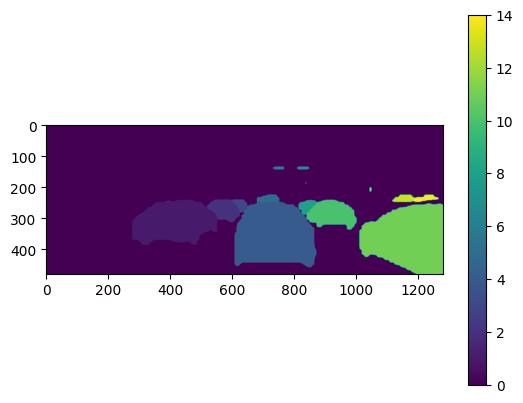

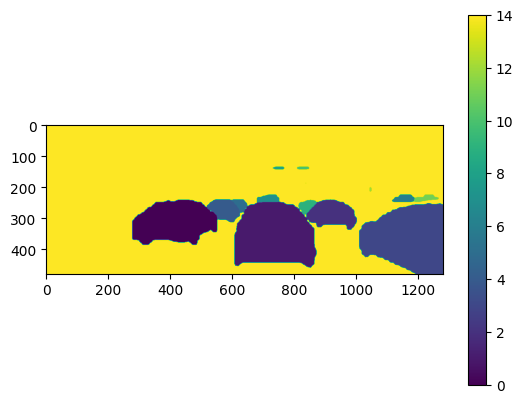

In [27]:

import matplotlib.pyplot as plt
plt.imshow(target_mask.cpu().numpy())
plt.colorbar()
plt.show() 
plt.imshow(max_idx.cpu().numpy())
plt.colorbar()
plt.show() 

In [33]:
aa = torch.zeros_like(max_idx)
for infer_num, gt_num in match:
    print(infer_num,gt_num)

0 11.0
1 13.0
2 12.0
0 0.0
1 1.0
2 10.0
3 6.0
4 8.0
5 5.0
6 3.0
0 2.0
0 7.0
1 9.0


In [34]:
print(outputs_batch.shape)

(13, 298)


In [16]:
mAP, ap_all = evaluate.evaluate(gt_boxes_all,det_boxes, all_classes, iou_thresh=0.5)
print(mAP[0])
print(ap_all)

99.51245
[array([ 99.67226 ,  99.30796 ,  98.64253 ,  99.59111 ,  99.462654,
        99.51532 ,  99.57706 ,  99.81185 ,  99.6403  ,  99.375   ,
        99.467926,  99.673744,  99.54534 ,  99.74683 ,  99.99988 ,
        98.7098  ,  99.565254,  99.03883 ,  99.63192 ,  99.80036 ,
        99.57877 ,  99.49092 , 100.      ,  99.68996 ,  99.11423 ,
        99.60651 ,  99.778595, 100.      ,  99.16678 ,  99.1316  ,
        99.00899 , 100.      ,  99.33969 ,  99.50739 ,  99.74651 ],
      dtype=float32)]


In [29]:
print(det_boxes[0][0])
print(gt_boxes_all[0])

[[1.14065820e+03 2.07093658e+02 1.18576025e+03 3.06406525e+02
  9.73893404e-01]
 [9.65957947e+02 2.23028198e+02 9.93839783e+02 2.87303040e+02
  9.64220226e-01]]
[[ 258.          251.          532.          405.            3.        ]
 [ 258.          251.          532.          405.            8.        ]
 [ 258.          251.          532.          405.           19.        ]
 [ 551.          243.00001526  579.          261.            3.        ]
 [ 551.          243.00001526  579.          261.           10.        ]
 [ 551.          243.00001526  579.          261.           20.        ]
 [ 579.          238.          633.          279.            3.        ]
 [ 579.          238.          633.          279.            8.        ]
 [ 579.          238.          633.          279.           19.        ]
 [ 631.          239.          655.          258.            3.        ]
 [ 631.          239.          655.          258.            8.        ]
 [ 631.          239.          655. 

In [16]:
ii=6
print(box[ii])
print(cls[ii])
#print(before[0].shape)
print(outputs[ii][:,0:4].cpu().numpy().astype(int))
print(outputs[ii][:,5:].cpu().numpy())

tensor([[4.2200e+02, 2.8700e+02, 4.5800e+02, 3.0600e+02],
        [5.0100e+02, 2.8300e+02, 5.1100e+02, 2.9100e+02],
        [5.1200e+02, 2.8400e+02, 5.2300e+02, 2.9200e+02],
        [5.5800e+02, 2.8300e+02, 6.0600e+02, 3.1700e+02],
        [6.2300e+02, 2.8400e+02, 6.4700e+02, 3.0300e+02],
        [6.7800e+02, 2.5500e+02, 7.1000e+02, 3.0900e+02],
        [7.0000e+02, 1.9500e+02, 8.1100e+02, 3.4800e+02],
        [7.9700e+02, 1.0000e+00, 1.2790e+03, 4.7800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0')
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0

35


In [16]:
print(len(det_boxes[0]))

96


In [19]:
print(det_boxes[3])
print(len(gt_boxes_all[3]))

[array([[605.22338867, 245.21859741, 686.19836426, 304.82730103,
          0.98139381],
       [508.99435425, 246.29782104, 563.10113525, 280.94839478,
          0.9789803 ],
       [173.15115356, 250.53791809, 306.32608032, 290.79681396,
          0.9766705 ],
       [378.82632446, 247.12765503, 479.4548645 , 309.92630005,
          0.97605908],
       [338.11581421, 246.81138611, 397.75576782, 271.85235596,
          0.9672091 ],
       [451.30792236, 225.85217285, 492.85565186, 264.19482422,
          0.96623063],
       [556.28234863, 246.29316711, 586.04248047, 266.98013306,
          0.96350986],
       [573.07354736, 240.01739502, 595.62261963, 259.06863403,
          0.95837545],
       [494.66662598, 246.91923523, 516.38543701, 259.94161987,
          0.93600357]]), array([[8.23523987e+02, 2.29215698e+02, 1.01044745e+03, 3.37393616e+02,
        9.86002445e-01],
       [7.38837219e+02, 2.40850845e+02, 8.48279602e+02, 2.84815155e+02,
        9.75308061e-01],
       [1.07767834e+

In [64]:

print(gt_boxes_all[0])

[[587.         259.          60.          44.           3.        ]
 [587.         259.          60.          44.          10.        ]
 [587.         259.          60.          44.          20.        ]
 [628.         255.          34.          26.           3.        ]
 [628.         255.          34.          26.          10.        ]
 [628.         255.          34.          26.          20.        ]
 [644.5        250.50001526  17.          19.           4.        ]
 [644.5        250.50001526  17.          19.          10.        ]
 [644.5        250.50001526  17.          19.          20.        ]
 [671.         253.99998474  30.          26.           3.        ]
 [671.         253.99998474  30.          26.           7.        ]
 [671.         253.99998474  30.          26.          19.        ]
 [929.         217.5         60.          25.           3.        ]
 [929.         217.5         60.          25.          15.        ]
 [929.         217.5         60.          25.   